,Tanggal,qty,Jumlah
Tanggal,,,
2016-01-01,2016-01-01,8694,63467076.0
2016-01-02,2016-01-02,10044,73320032.0
2016-01-03,2016-01-03,13928,101671188.0
2016-01-04,2016-01-04,12518,91382972.0
2016-01-05,2016-01-05,11112,77424375.0
...,...,...,...
2021-10-25,2021-10-25,12239,93628350.0
2021-10-26,2021-10-26,11319,86590350.0
2021-10-27,2021-10-27,12502,95640300.0


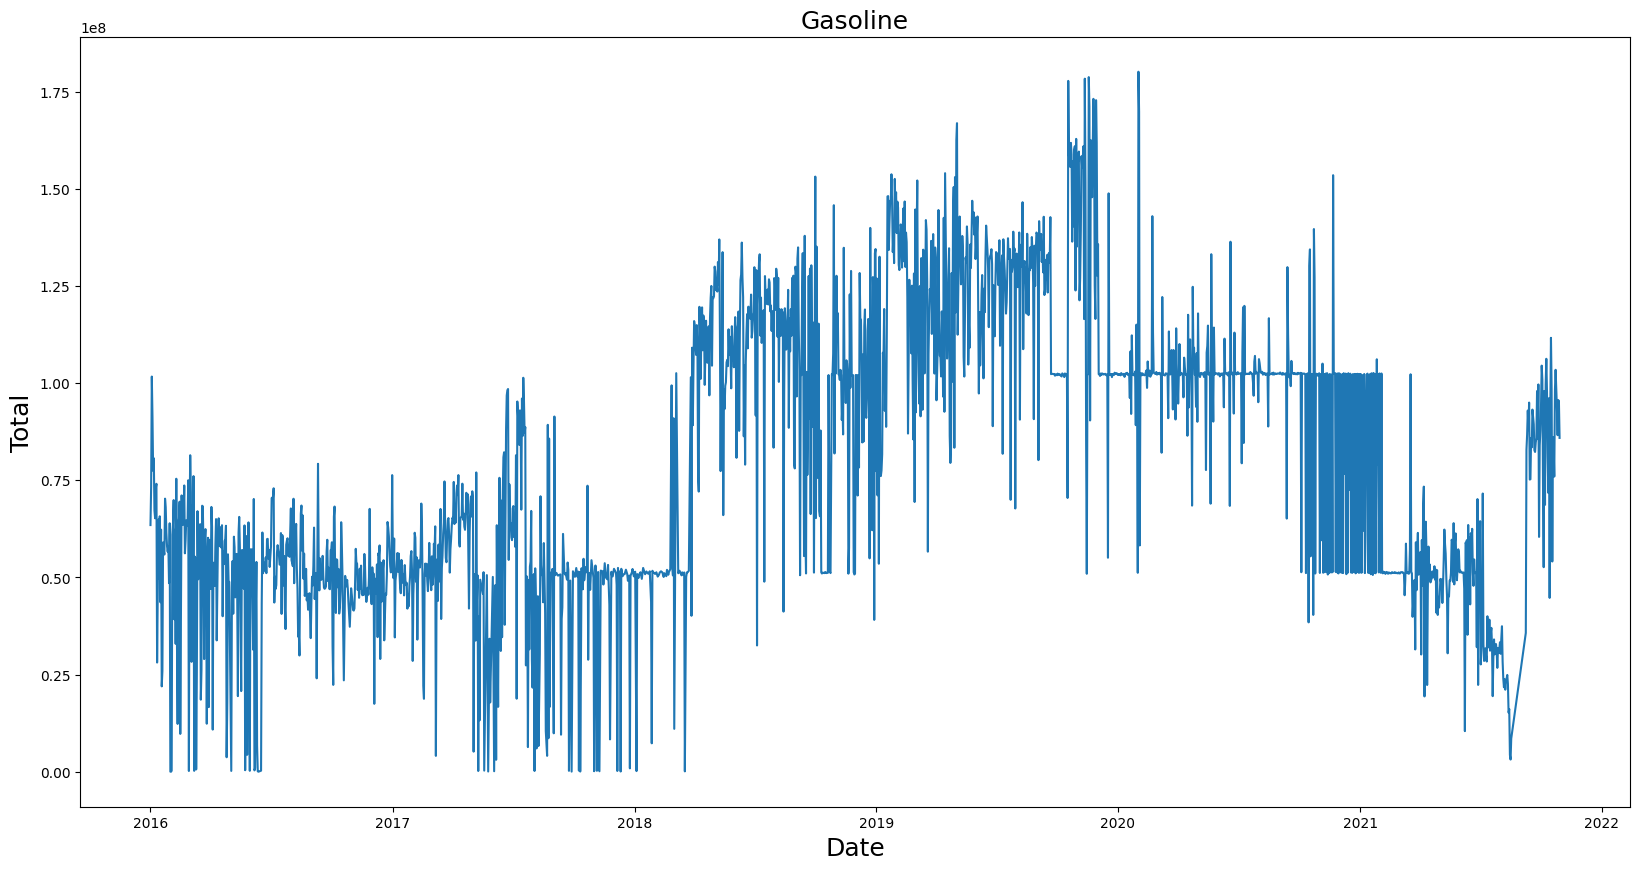

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Load dataset
df = pd.read_csv('Gasoline.csv')

# Set Tanggal as datetime index
df['Tanggal'] = pd.to_datetime(df.Tanggal, format='%Y-%m-%d')
df.index = df['Tanggal']

# Plot dataset
plt.figure(figsize=(20, 10))
plt.plot(df['Jumlah'], label='History Harga Penutup')
plt.title('Gasoline', fontsize=18)
plt.ylabel('Total', fontsize=18)
plt.xlabel('Date', fontsize=18)

df

In [10]:
# Min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Tanggal', 'Jumlah'])
for i in range(0, len(df)):
    new_data['Tanggal'][i] = data['Tanggal'][i]
    new_data['Jumlah'][i] = data['Jumlah'][i]

new_data.index = new_data['Tanggal']
new_data.drop('Tanggal', axis=1, inplace=True)

dataset = new_data.values

# Train-test split
train, valid = train_test_split(dataset, test_size=0.2, shuffle=False)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Prepare data for training
x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



/tmp/ipykernel_22758/2357206698.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Tanggal'][i] = data['Tanggal'][i]
/tmp/ipykernel_22758/2357206698.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Jumlah'][i] = data['Jumlah'][i]



Training with 5 epochs...

Epoch 1/5
308/308 [==============================] - 14s 38ms/step - loss: 0.0191 - val_loss: 0.0156
Epoch 2/5
308/308 [==============================] - 12s 38ms/step - loss: 0.0146 - val_loss: 0.0107
Epoch 3/5
308/308 [==============================] - 11s 37ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 4/5
308/308 [==============================] - 11s 37ms/step - loss: 0.0136 - val_loss: 0.0110
Epoch 5/5
13/13 [==============================] - 0s 11ms/step

Training with 10 epochs...

Epoch 1/10
308/308 [==============================] - 14s 38ms/step - loss: 0.0180 - val_loss: 0.0111
Epoch 2/10
308/308 [==============================] - 11s 35ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 3/10
308/308 [==============================] - 11s 37ms/step - loss: 0.0141 - val_loss: 0.0106
Epoch 4/10
308/308 [==============================] - 11s 37ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 5/10
308/308 [==============================] - 11s 37ms/step

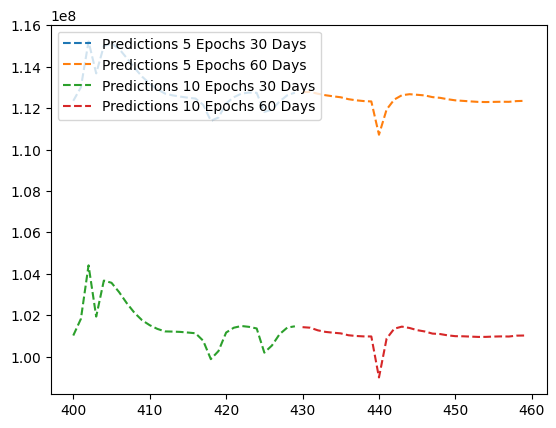

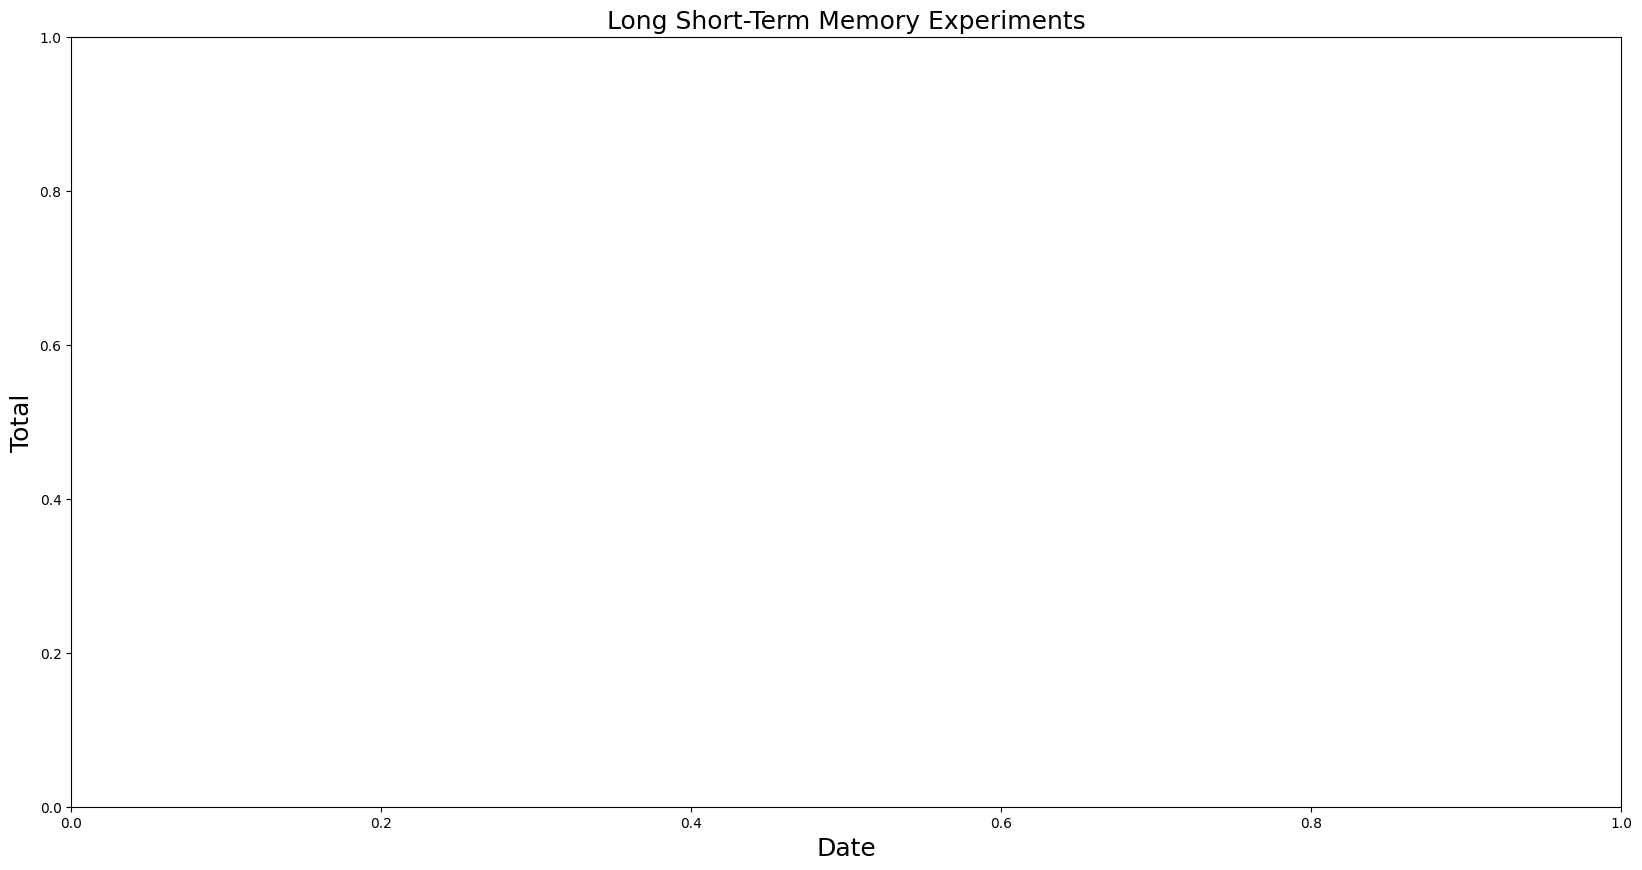

In [13]:
# Define the number of epochs to experiment with
epochs_list = [5, 10,50,100]

# Run experiments
for epochs in epochs_list:
    print(f"\nTraining with {epochs} epochs...\n")

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=60))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=5, verbose=1, validation_data=(x_train, y_train))

    # Prepare data for testing
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    x_test = []
    for i in range(60, inputs.shape[0]):
        x_test.append(inputs[i - 60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predictions
    closing_price_30 = []
    closing_price_60 = []

    for i in range(30):
        next_day_prediction = model.predict(x_test)
        closing_price_30.append(next_day_prediction[0, 0])
        x_test = np.roll(x_test, -1)
        x_test[-1, -1] = next_day_prediction[0, 0]

    for i in range(30, 60):
        next_day_prediction = model.predict(x_test)
        closing_price_60.append(next_day_prediction[0, 0])
        x_test = np.roll(x_test, -1)
        x_test[-1, -1] = next_day_prediction[0, 0]

    # Inverse transform to get the denormalized values
    closing_price_30 = scaler.inverse_transform(np.array(closing_price_30).reshape(-1, 1))
    closing_price_60 = scaler.inverse_transform(np.array(closing_price_60).reshape(-1, 1))

    # Plot predictions
    plt.plot(range(len(valid), len(valid) + 30), closing_price_30, label=f'Predictions {epochs} Epochs 30 Days', linestyle='--')
    plt.plot(range(len(valid) + 30, len(valid) + 60), closing_price_60, label=f'Predictions {epochs} Epochs 60 Days', linestyle='--')

# Plot legends and show the plot
plt.legend(loc="upper left")
plt.title('Long Short-Term Memory Experiments', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total', fontsize=18)
plt.show()
